## 训练集和测试集

In [1]:
import pandas as pd
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
train_data

,Unnamed: 0,index,id,text,BIO_anno,class
0,0,1505,1505,挺快的了，我是8月底下的卡，今年51提的。,B-COMMENTS_ADJ I-COMMENTS_ADJ O O O O O O O O ...,2
1,1,1506,1506,我显示汇总过高了，今天下了中信4万，准备把招商注销了,O O O O O B-COMMENTS_ADJ I-COMMENTS_ADJ O O O ...,2
2,2,1507,1507,刷超市银行利润低,O O O O O O O B-COMMENTS_ADJ,2
3,3,1508,1508,你这个网速是怎么加的呢，慢死了,O O O O O O O O O O O O B-COMMENTS_ADJ O O,2
4,4,1509,1509,我12月份下的卡，一直有临额今天到期临时额度没有了，这个月刚好是调额月，怕进黑屋,O O O O O O O B-PRODUCT O O O O B-COMMENTS_N I...,2
...,...,...,...,...,...,...
6018,6018,7523,7523,我鼎级拒了,O O O B-COMMENTS_ADJ O,2
6019,6019,7524,7524,一打一个准，准胜，看激活信用卡时那协议，全是对银行有利的,O O O O O O O O O O B-COMMENTS_N I-COMMENTS_N ...,2
6020,6020,7525,7525,招行分期白80k,B-BANK I-BANK B-PRODUCT I-PRODUCT I-PRODUCT O O O,2
6021,6021,7526,7526,5万，额度还行吧没毕业哦,O O O B-COMMENTS_N I-COMMENTS_N O O O O O O O,2


## 导入模型参数

In [2]:
class Config():
    def __init__(self) -> None:
        self.pretrained_model_path = 'pretrained_models/bert-large-chinese/'
        self.hidden_size = 256
        self.dropout = 0.2
        self.label_size = 9
        self.model = 'D_BERT_BiLSTM_CRF'
        self.device = 'cuda:2'
        self.batch_size = 16
        
config = Config()

## 定义模型

In [3]:
import torch 
import torch.nn as nn
from transformers import BertModel
from torchcrf import CRF
model_saved_path = 'data/D_BERT_BiLSTM_CRF_weights.bin'
    
class Model(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config
        
        self.bert = BertModel.from_pretrained(self.config.pretrained_model_path, output_hidden_states=True)
        self.fc1 = nn.Linear(24*1024, 1024)       # weight merge
        self.lstm = nn.LSTM(
            1024,
            self.config.hidden_size,
            batch_first = True,
            bidirectional = True
        )
        self.dropout = nn.Dropout(self.config.dropout)
        self.fc2 = nn.Linear(self.config.hidden_size*2, self.config.label_size)
        self.crf = CRF(self.config.label_size, batch_first=True)
        
    def forward(self, input_ids, label_ids, mask):
        att_mask = torch.ne(mask, 0)
        bert_output = self.bert(input_ids, attention_mask=att_mask)
        hidden_states = bert_output[2][1:]  # 除去embdding层
        B, S, _ = hidden_states[0].shape    # batch_size, seq_len, embed_dim
        hidden_states = torch.stack(hidden_states, dim=3)   # 把新维度放到最后: (batch_size, seq_len, embed_dim, num_layers=12)
        hidden_states = hidden_states.view(B, S, -1)    
        # hidden_states： （batch_size, seq_len, 12*embed_dim)
        sequence_output = self.fc1(hidden_states)
        sequence_output = self.dropout(sequence_output)
        # sequence_output: (batch_size, sequence_length, embed_dim=768)
        sequence_output, _ = self.lstm(sequence_output)
        # sequence_output: (batch_size, seq_len, HIDDEN_SIZE*2)
        logits = self.fc2(sequence_output)
        # logits: (batch_size, seq_len, LABEL_SIZE=9)
        tags = self.crf.decode(logits, att_mask)
        # tags: List of list containing the best tag sequence for each batch.
        
        return tags 
    
    def loss_fn(self, input_ids, label_ids, mask):
        att_mask = torch.ne(mask, 0)
        bert_output = self.bert(input_ids, attention_mask=att_mask)
        hidden_states = bert_output[2][1:]  # 除去embdding层
        B, S, _ = hidden_states[0].shape    # batch_size, seq_len, embed_dim
        hidden_states = torch.stack(hidden_states, dim=3)   # 把新维度放到最后: (batch_size, seq_len, embed_dim, num_layers=24)
        hidden_states = hidden_states.view(B, S, -1)    
        # hidden_states： （batch_size, seq_len, 24*embed_dim)
        sequence_output = self.fc1(hidden_states)
        sequence_output = self.dropout(sequence_output)
        # sequence_output: (batch_size, sequence_length, embed_dim=1024)
        sequence_output, _ = self.lstm(sequence_output)
        # sequence_output: (batch_size, seq_len, HIDDEN_SIZE*2)
        logits = self.fc2(sequence_output)
        # logits: (batch_size, seq_len, LABEL_SIZE=9)
        if label_ids != None:
            loss = self.crf(logits, label_ids, att_mask)
        return loss*(-1)      

model = Model(config)
model.load_state_dict(torch.load(model_saved_path))
model = model.to(config.device)

Some weights of the model checkpoint at pretrained_models/bert-large-chinese/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 创建Dataset, Dataloader

In [4]:
import torch
import torch.utils.data as data
from transformers import AutoTokenizer
import pandas as pd


class Dataset(data.Dataset):
    def __init__(self, config, data) -> None:
        super().__init__()
        self.config = config
        self.data = data
        self.label2id = self.get_dict('data/label.txt')
        self.char2id = self.get_dict('data/vocab.txt')
        
    def get_dict(self, dict_path):
        '''
        将存起来的vocab和labels文件转化成字典映射
        '''
        df = pd.read_csv(dict_path, names=['char', 'id'])
        mapping = {}
        for i in range(1, len(df)):
            mapping[df['char'][i]] = df['id'][i]
        return mapping
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data['text'][idx]
        label = self.data['BIO_anno'][idx]
        # 把label中的字符转化成对应的数值标签
        # label_num = [self.label2id.get(v, self.config.pad_id) for v in label.split(' ')]
        return text, label

class Dataloader():
    def __init__(self, config, dataset) -> None:
        self.config = config
        self.dataset = dataset
        self.label2id = self.dataset.label2id
        self.dataloader = self.get_dataloader(dataset)
    
    def tokenize(self, texts, labels):
        # 给无预训练tokenizer的模型编码
        text_nums, label_nums = [], []
        char2id = self.dataset.char2id
        max_len = len(texts[0])
        for i in range(len(texts)):
            label = labels[i]
            label_num = [self.label2id.get(v, self.config.pad_id) for v in label.split(' ')]
            pad_len = max_len - len(texts[i])
            text_li = list(texts[i]) + pad_len * self.config.pad_id
            label_li = label_num + pad_len * self.config.pad_id
            assert len(text_li) == len(label_li), 'wrong len of text and label'
            text_num = [char2id.get(v, 1) for v in text_li if isinstance(v, str)]
            text_nums.append(text_num)
            label_nums.append(label_li)
        return text_nums, label_nums
                   
    def collate_fn(self, batch_samples):
        # 按照当前批次中文本长度排序，方便pad
        batch_samples.sort(key=lambda x:len(x[0]), reverse=True)
        # max_len = len(batch_samples[0][0])
        texts, labels = [], []
        for sample in batch_samples:
            texts.append(sample[0])
            labels.append(sample[1].split(' '))
            assert len(sample[0]) == len(sample[1].split(' ')), 'wrong length of text and label'
        if 'BERT' not in self.config.model:
            # 不用预训练模型
            text_encod, label_encod = self.tokenize(texts, labels)
        else:
            tokenizer = AutoTokenizer.from_pretrained(self.config.pretrained_model_path)
            text_encod = tokenizer(
                texts, 
                padding=True,
                truncation=True,
                return_tensors='pt',
                max_length=256
            )
            formated_labels = self.formated_label(labels)
            label_encod = torch.zeros_like(
                text_encod['input_ids']
            )
            for idx, text in enumerate(texts):
                encoding = tokenizer(text, truncation=True, max_length=256, padding=True)
                label_encod[idx][0] = 0   
                label_encod[idx][len(encoding.tokens())-1:] = 0 
                for char_start, char_end, tag in formated_labels[idx]:
                    token_start = encoding.char_to_token(char_start)
                    token_end = encoding.char_to_token(char_end)
                    label_encod[idx][token_start] = int(self.label2id[f'B-{tag}'])
                    label_encod[idx][token_start+1:token_end+1] = int(self.label2id[f'I-{tag}'])
        return text_encod.to(self.config.device), torch.LongTensor(label_encod).to(self.config.device)
    
    # def formated_label(self, labels):
    #     formated_labels = [[] for _ in range(len(labels))]
    #     for i, label in enumerate(labels):
    #         idx = 0
    #         while idx < len(label):
    #             if label[idx].startswith('B-'):
    #                 start_idx = idx
    #                 while idx < len(label) and label[idx] != 'O':
    #                     idx += 1
    #                 end_idx = idx - 1
    #                 formated_labels[i].append([start_idx, end_idx, label[start_idx][2:]])
    #                 # 结果类似于[7, 9, BANK]
    #             idx += 1
    #     return formated_labels       
    
    def formated_label(self, labels):
        formated_labels = [[] for _ in range(len(labels))]
        for i, label in enumerate(labels):
            for j, v in enumerate(label):
                if v.startswith('B-'):
                    formated_labels[i].append([j, j, v[2:]])
                elif v.startswith('I-'):
                    formated_labels[i][-1][1] = j
        return formated_labels     
                    
    def get_dataloader(self, dataset):
        dataloader = data.DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            # num_workers=self.config.num_workers,
            collate_fn=self.collate_fn
        )
        return dataloader
    

In [5]:
test_dataset = Dataset(config, test_data)
test_dataloader = Dataloader(config, test_dataset).dataloader

## 坏例分析

In [6]:
tokenizer = AutoTokenizer.from_pretrained(config.pretrained_model_path)
labelid2label = {0:'O', 1:'I-PRODUCT', 2:'B-COMMENTS_ADJ', 3:'I-COMMENTS_N', 4:'B-COMMENTS_N',
                5:'B-PRODUCT', 6:'I-COMMENTS_ADJ', 7:'I-BANK', 8:'B-BANK'}
wrong_samples = {'O':0, 'I-PRODUCT':0, 'B-COMMENTS_ADJ':0, 'I-COMMENTS_N':0, 'B-COMMENTS_N':0, 
                'B-PRODUCT':0, 'I-COMMENTS_ADJ':0, 'I-BANK':0, 'B-BANK':0}

def testing(dataloader, model):
    model.eval()
    Y_pred, Label = [], []
    with torch.no_grad():
        for batch, (text_encoding, label_ids) in enumerate(dataloader):
            input_ids = text_encoding['input_ids']
            mask = text_encoding['attention_mask'] 
            # y_pred的例子 ：[[1, 2, 3], [2, 3], [1]], 之所以长度不同是因为有mask的存在。长度递减是因为dataloader中按照长度给输入排序了。
            y_pred = model(input_ids, label_ids, mask)
            # 把y_pred填充成label_ids 的形状
            max_len = len(label_ids[0])
            for row in y_pred:
                if len(row) < max_len:
                    row += [0]*(max_len-len(row))
            y_pred = torch.tensor(y_pred).flatten().cpu()
            Y_pred += y_pred.tolist()
            label_ids = label_ids.flatten().cpu()
            Label += label_ids.tolist()
    return Y_pred, Label

y_pred, label = testing(test_dataloader, model)

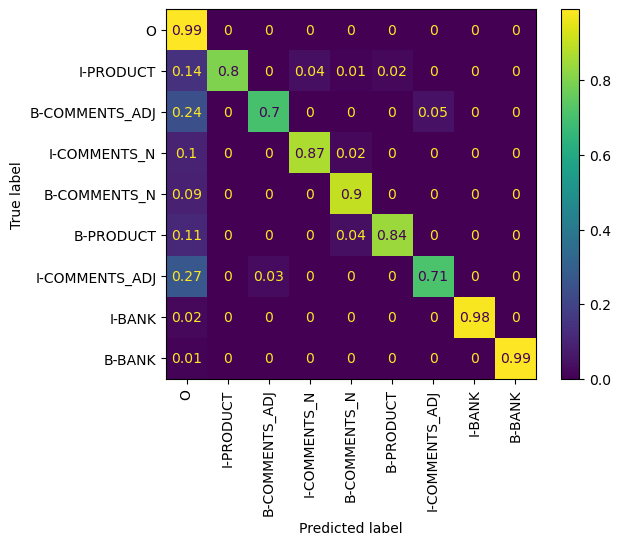

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
labels = pd.read_csv('data/label.txt')
conf_mat = confusion_matrix(label, y_pred)
row_sums = conf_mat.sum(axis=1, keepdims=True)   # 标准化一下，否则量纲相差太大
norm_conf_mat = conf_mat/row_sums
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(norm_conf_mat, 2), display_labels=labels['label'])
disp.plot(
    include_values=True,     # 混淆矩阵每个单元格上显示具体数值
    cmap='viridis',
    ax=None,
    xticks_rotation='vertical',
    values_format='.2g'
)

观察上图可以发现，基本上错误都是将其他实体误判为了0(O)，特别是6（I-COMMENTS_ADJ）和2（B-COMMENTS_ADJ），因此我们可以考虑对其他数据做数据增强以提升模型对其他数据的理解。

方法为统计所有除0（O）以外的其他数对应的实体名字，然后再随机替换。注意，我们不能只替换单个字符，而是应该替换整个实体，为此我们先统计所有种类的实体。

In [25]:
def get_row_entities(data, row, type):
    res = []
    label = data['BIO_anno'][row].split(' ')
    text = list(data['text'][row])
    for i, v in enumerate(label):       
        if res and v.startswith('I-'):      # 说明当前词在上一个实体的中间
            res[-1] += text[i]
        elif type in v:
            res.append(text[i])
    return res  
print(get_row_entities(train_data, 120, 'COMMENTS_ADJ'))        # 120行没有 'COMMENTS_ADJ'
print(get_row_entities(train_data, 0, 'COMMENTS_ADJ'))

[]
['挺快']


对所有行和所有类别进行此操作，把结果存起来备用。

In [26]:
entities = {'PRODUCT':[], 'COMMENTS_ADJ':[], 'COMMENTS_N':[], 'BANK':[]}
for row in range(len(train_data)):      # 所有行
    for type in ['PRODUCT', 'COMMENTS_ADJ', 'COMMENTS_N', 'BANK']:  # 所有类别
        entities[type] += get_row_entities(train_data, row, type)

In [27]:
for type in entities.keys():
    print(f'length of entity {type} is {len(entities[type])}')

length of entity PRODUCT is 3489
length of entity COMMENTS_ADJ is 3862
length of entity COMMENTS_N is 3534
length of entity BANK is 2055


接下来我们将每种实体按照长度分类：

In [28]:
for type in ['PRODUCT', 'COMMENTS_ADJ', 'COMMENTS_N', 'BANK']:
    entities[type].sort(key = lambda x : len(x), reverse=True)
    
PRODUCT, COMMENTS_ADJ, COMMENTS_N, BANK = {}, {}, {}, {}
for type in ['PRODUCT', 'COMMENTS_ADJ', 'COMMENTS_N', 'BANK']:
    for v in entities[type]:
        if len(v) in eval(type).keys():
            if v not in eval(type)[len(v)]:     # 去除重复的实体
                eval(type)[len(v)] += [v]
        else:
            eval(type)[len(v)] = [v]
PRODUCT

{22: ['信用卡国银行商银行业银行设银行安银行商银行错'],
 17: ['line friends的信用卡度'],
 13: ['分期债度行储通发信安海州苏'],
 12: ['分期可以债商设行大行夏发',
  '信用卡度少账度少息少谢期',
  '魔都优逸白金信用卡卡较好',
  '公安便民龙卡信用卡卡度度',
  '微粒贷设业政商夏丰信生州'],
 11: ['app了费准确费费准确', '招商银行星座守护信用卡', '信用卡支度产入产多入多', '钻石精英、无限visa'],
 10: ['信用卡费户固额定额度',
  '固定额度提升续费固定',
  '香白3136环球双M',
  '征信的很款行单优款款',
  '美国运通百夫长信用卡',
  '掌上生活app信银行',
  '兴享贷清续费清业续费'],
 9: ['首卡度时额度固定度',
  '百夫长白金期卡费卡',
  '信用卡时额度定额度',
  'Young卡用卡卡',
  '周五饭票五折通银行',
  'Clear透明金卡',
  '星座白金信用卡星级',
  '积分厚行算度度低度',
  '芭比白的信用卡本费',
  '信用卡度坑卡度力度',
  '信用卡信银行国银行',
  '股票、期货、外汇险',
  'niubility',
  '阳光惠生活app卡'],
 8: ['小白金费续费费费',
  '掌上生活续费续费',
  '现金分期期定额度',
  '按期还钱务逾期准',
  '掌上生活度信贷额',
  '分期期度长能度度',
  '卡片核过心度法能',
  '炫萌萌白金信用卡',
  '分期降债行大行发',
  '融e借度度度度度',
  '信用卡度期金息商',
  'U盾想行须水少高',
  '上交大复旦联名卡',
  '标准白金卡额大难',
  'applepay',
  'i白金对销卡快了',
  '信用卡度信控有款',
  '动卡空间app好',
  '客服好速好丰富欢',
  '哔哩哔哩联名卡安',
  '哔哩哔哩联名卡行',
  '信用卡缴款现续费',
  '白金卡币民币币费',
  '鲁通卡设银行费费',
  '信用卡业息长期款',
  '中银e贷化通生信',
  '手机银行APP活',
  '犀利卡债高常费卡'],
 7: ['储蓄卡需要好了',
  '预约受理核核核

## 实体数据增强
我们需要遍历训练集中每一行，然后以`0.7`的概率决定是否对其进行数据增强。
* 如果要增强，那么我们就获取其中所有实体。
    -  如果此行没有实体，那我们就随机删除其中几个`O`。
    - 如果此行有实体，那我们用相同长度的其他实体随机替换掉其中的一个实体，然后随机重复几次。
* 如果不增强，则跳过此行。

In [29]:
from random import randint
kinds = ['PRODUCT', 'COMMENTS_ADJ', 'COMMENTS_N', 'BANK']

def get_random_replace(dic, length):
    idx = randint(1, len(dic[length])-1)
    return dic[length][idx]

def get_augment(data, row):
    
    if not randint(1, 10)%3:    # 70%增强
        return None
    labels = data['BIO_anno'][row].split(' ')
    text = list(data['text'][row])
    i = 0
    while i < len(labels):
        label = labels[i]
        if any((kind in label for kind in kinds)) and label.startswith('B-'):      # label中有实体且是以B-开头的
            j = i
            while labels[j][2:] != label[2:]:             # 找出当前实体范围
                j += 1
            length = j - i
            if length in eval(label[2:]).keys():
                text[i:j] = get_random_replace(eval(label[2:]), j-i)     # label[2:] : 去掉 B- 和 I- 的剩余部分
                i = j
            else:
                i += 1
            if randint(1, 10)%2:        # 50%概率不继续替换
                return text, labels
        else:
            num_delete = randint(1, len(text)-1)       # 随机删除的数量
            for i in range(num_delete):
                idx = randint(0, num_delete-1)           # 删除的位置
                text = text[:idx] + text[idx+1:]
                labels = labels[:idx] + labels[idx+1:]
                if not randint(1, 10)%3:
                    return text, labels
            return text, labels

augmented_data = train_data[['text', 'BIO_anno']]
n = len(train_data)
for row in range(n):
    new = get_augment(augmented_data, row)
    if not new:
        continue
    new_text, label = new
    augmented_data.loc[len(augmented_data), ['text', 'BIO_anno']] = ''.join(new_text), ' '.join(label)
print(label)

/tmp/ipykernel_155128/3215866397.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_data.loc[len(augmented_data), ['text', 'BIO_anno']] = ''.join(new_text), ' '.join(label)


['B-BANK', 'I-BANK', 'I-BANK', 'I-BANK', 'I-BANK', 'O', 'B-BANK', 'I-BANK', 'I-BANK', 'I-BANK', 'O', 'B-BANK', 'I-BANK', 'I-BANK', 'I-BANK', 'O', 'O']


In [30]:
AUGMENTED_DATA_PATH = 'data/' + 'augmented.csv'
augmented_data.to_csv(AUGMENTED_DATA_PATH)
augmented_data

,text,BIO_anno
0,挺快的了，我是8月底下的卡，今年51提的。,B-COMMENTS_ADJ I-COMMENTS_ADJ O O O O O O O O ...
1,我显示汇总过高了，今天下了中信4万，准备把招商注销了,O O O O O B-COMMENTS_ADJ I-COMMENTS_ADJ O O O ...
2,刷超市银行利润低,O O O O O O O B-COMMENTS_ADJ
3,你这个网速是怎么加的呢，慢死了,O O O O O O O O O O O O B-COMMENTS_ADJ O O
4,我12月份下的卡，一直有临额今天到期临时额度没有了，这个月刚好是调额月，怕进黑屋,O O O O O O O B-PRODUCT O O O O B-COMMENTS_N I...
...,...,...
10248,等，我卡到了，还没发现什么进展。焦虑,O O O O O O O O O O O O O O O O B-COMMENTS_ADJ...
10249,一打一个，胜看活信用卡时那协议，是对银行有利的,O O O O O O O I-COMMENTS_N B-PRODUCT I-PRODUCT...
10250,招行分期白80k,B-BANK I-BANK B-PRODUCT I-PRODUCT I-PRODUCT O O O
10251,，额度还行吧没毕业哦,O B-COMMENTS_N I-COMMENTS_N O O O O O O O


可以看到，经过数据增强，我们得到了额外的4230条数据。接下来我们用新生成的数据训练，然后在测试集上实验。